### Import libraries

In [18]:
import sys; sys.path.insert(0, '..')
import os

import ee
import numpy as np
import geemap
from osgeo import gdal

import settings_BID
import utils

ee.Initialize()

### Define parameters

In [2]:
# [lat, lon]
sauce_center = [-34.83326008, -55.05417706]
center_point = ee.Geometry.Point(sauce_center[1], sauce_center[0])
# [[lon, lat]]
sauce_zone = [[-55.16629529644229, -34.7494869239046],
              [-55.02038312603214, -34.7494869239046],
              [-55.02038312603214, -34.868725532230165],
              [-55.16629529644229, -34.868725532230165],
              [-55.16629529644229, -34.7494869239046]]
sauce_geometry = ee.Geometry.Polygon(sauce_zone)
#Dates to filter
start = ee.Date('2020-03-23')
finish = ee.Date('2020-03-25')
# RGB + near infrared
bands = ['B5', 'B4', 'B3', 'B2']

### Get data with GEE, clip area and obtain download link

In [3]:
filteredCollection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(sauce_geometry) \
    .filterDate(start, finish)

count = filteredCollection.size()

image = filteredCollection.first().clip(sauce_geometry)
url = image.getDownloadURL()
print(url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f86cff95fc043d7793b4e28bb3a3cc25-6c393f28bdb41eb8bb7b9409268af835:getPixels


### Download data from link

In [5]:
import requests
import os
import zipfile

def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

save_path = settings_BID.data_path
print(save_path)
try:
    os.makedirs(save_path)
except FileExistsError as e:
    print("Directory already exists")
zip_path = os.path.join(save_path, "data.zip")
download_url(url, os.path.join(save_path, "data.zip"))
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(save_path)

C:\Users\enzot\Documents\Maestria\Cianobacterias\code\BID\data\2020-03-24


### Create GeoTiff for RGB

In [22]:
bands_data = {}
RGB_bands = ["B2", "B3", "B4"]
for b in RGB_bands:
    for file in os.listdir(settings_BID.data_path):
        if file.endswith(b+".tif"):
            tiff_path = os.path.join(settings_BID.data_path, file)
            ds = gdal.Open(tiff_path, gdal.GA_ReadOnly)
            rb = ds.GetRasterBand(1)
            img_array = rb.ReadAsArray()
            bands_data[b] = img_array

rgb_geotiff_path = os.path.join(settings_BID.data_path, "laguna-RGB.tif")
# set geotransform
nx = bands_data["B2"].shape[1]
ny = bands_data["B2"].shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(rgb_geotiff_path, nx, ny, 3, gdal.GDT_Float32)
# load tif to get coords from
ds = gdal.Open(tiff_path)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(bands_data["B4"])   # write band to the raster
dst_ds.GetRasterBand(2).WriteArray(bands_data["B3"])   # write band to the raster
dst_ds.GetRasterBand(3).WriteArray(bands_data["B2"])   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Display RGB

Min: -134
Max: 5956
Min: 116
Max: 10942
Min: 74
Max: 10559


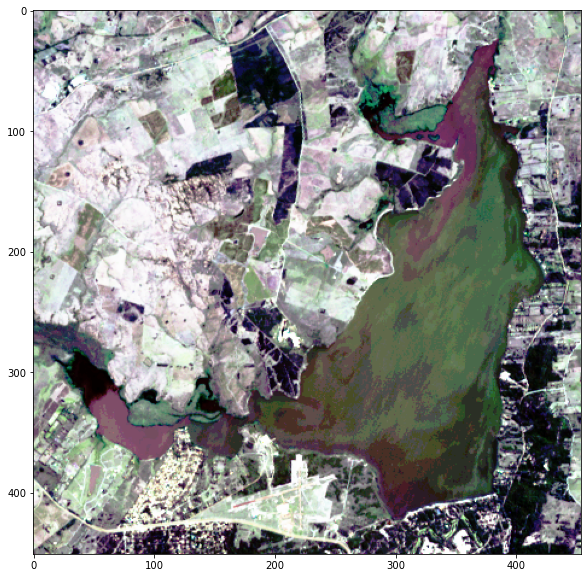

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
bgr_array = np.zeros((bands_data["B2"].shape[0], bands_data["B2"].shape[1], 3), dtype=np.uint8)

bgr_array[:, :, 0] = utils.stretch_to_MinMax(bands_data["B2"], verbose=True)
bgr_array[:, :, 1] = utils.stretch_to_MinMax(bands_data["B3"], verbose=True)
bgr_array[:, :, 2] = utils.stretch_to_MinMax(bands_data["B4"], verbose=True)

plt.imshow(utils.histogram_equalization(bgr_array))